In [11]:
import torch
import torch.nn as nn
import pytorch_lightning as pl 
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar, EarlyStopping

In [12]:
df = pd.read_csv('/Users/matheshanandan/Downloads/Time series aalysis/temperature_data_new_2024.csv')

In [13]:
df.columns

Index(['Unnamed: 0', 'date', 'temperature_2m', 'relative_humidity_2m',
       'precipitation', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'vapour_pressure_deficit', 'wind_speed_10m',
       'wind_gusts_10m', 'soil_temperature_0_to_7cm'],
      dtype='object')

In [14]:
df = df[['date', 'temperature_2m', 'relative_humidity_2m','weather_code']]

In [15]:
df

,date,temperature_2m,relative_humidity_2m,weather_code
0,2010-01-01 00:00:00+00:00,21.000000,94.60242,0.0
1,2010-01-01 01:00:00+00:00,21.150000,94.31649,0.0
2,2010-01-01 02:00:00+00:00,22.350000,92.64611,0.0
3,2010-01-01 03:00:00+00:00,24.950000,82.18280,1.0
4,2010-01-01 04:00:00+00:00,26.250000,72.43867,1.0
...,...,...,...,...
131491,2024-12-31 19:00:00+00:00,24.917501,84.21006,0.0
131492,2024-12-31 20:00:00+00:00,24.817501,83.68701,2.0
131493,2024-12-31 21:00:00+00:00,24.617500,83.92067,1.0
131494,2024-12-31 22:00:00+00:00,24.267500,85.17549,2.0


In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
INPUT_LENGTH = 24
OUTPUT_LENGTH = 8
class WeatherDataset(Dataset): 
    def __init__(self, df, input_length = INPUT_LENGTH, output_length = OUTPUT_LENGTH, scaler = None):
        self.input_length = input_length 
        self.output_length = output_length
        self.scaler = scaler
        self.features = self.scaler.transform(df.drop('date', axis =1))
    def __len__(self): 
        return len(self.features) - (self.input_length + self.output_length)

    def __getitem__(self, idx): 
        x = self.features[idx: idx + self.input_length]
        y = self.features[idx + self.input_length: idx + self.input_length+self.output_length, 0]

        return torch.tensor(x, dtype = torch.float32), torch.tensor(y, dtype = torch.float32)

train_df = df[df['date'] < '2022-01-01']
test_df = df[df['date'] >='2022-01-01']


scaler = StandardScaler()
scaler = scaler.fit(train_df.drop('date', axis = 1))

train_dataset = WeatherDataset(train_df, scaler= scaler)
test_dataset = WeatherDataset(test_df, scaler= scaler)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle= False)

In [19]:
INPUT_DIM = train_dataset.features.shape[1]
OUTPUT_DIM = 8
NUM_HEADS = 2
LR = 0.0001                                                                                                                                          
DROUPOUT =  0.5
HIDDEN_DIM = 246
NUM_LAYERS =  2

class TemporalFusionTransformer(pl.LightningModule):
    def __init__(self, input_dim = INPUT_DIM, output_length = OUTPUT_DIM, hidden_dim = HIDDEN_DIM, lr = LR, num_heads = NUM_HEADS, probabilistic =  False, num_layers = NUM_LAYERS, dropout = DROUPOUT):
        super(TemporalFusionTransformer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.output_length = output_length
        self.probabilistic = probabilistic
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size = input_dim, num_layers = num_layers, hidden_size = hidden_dim, batch_first = True, dropout = dropout)
        self.norm = nn.LayerNorm(hidden_dim)
        self.attention = nn.MultiheadAttention(embed_dim= hidden_dim, num_heads= NUM_HEADS, batch_first = True)
        self.glu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden_dim, 2 if probabilistic else 1)
      
        self.dropout = nn.Dropout(dropout)
        self.criterion = nn.MSELoss() if not probabilistic else self.null_loss

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.norm(lstm_out)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out) 
        combine = self.glu(attn_out) + lstm_out
        combine = self.dropout(combine)
        # print(combine.shape)
        out = self.fc(combine[:, -self.output_length:])
        # print(out.shape)
# [:, -self.output_length:, :]
        if self.probabilistic:
            mu, log_std = out[:, :, 0], out[:, :, 1]
            sigma = torch.exp(log_std)
            return mu, sigma
        else:
            out = out.squeeze(-1)
            # print(out.shape)
            return out
    
    def null_loss(self, predictions, targets):
        """Negative Log-Likelihood Loss for probabilistic forecasting."""
        mu, sigma = predictions        
        return torch.mean(0.5 * torch.log(2 * torch.pi * sigma**2) + (targets - mu)**2 / (2 * sigma**2))

    def training_step(self, batch, batch_idx): 
        x, y  = batch
        if self.probabilistic:
            mu, sigma = self(x)
            loss = self.null_loss((mu, sigma), y)
        else:
            y_pred = self(x).squeeze(-1)
            loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss 
        
    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        # print(x.shape)
        if self.probabilistic: 
            mu, sigma = self(x) 
            loss = self.null_loss((mu, sigma), y)
        else: 
            y_pred = self(x).squeeze(-1) 
            loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss 

    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

probabilistic = False
model = TemporalFusionTransformer(probabilistic =probabilistic) 


# Callbacks for monitoring performance
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", 
    save_top_k=3, 
    mode="min", 
    filename="tft-{epoch:02d}-{val_loss:.2f}")

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=2, mode="min")

progress_bar = TQDMProgressBar(refresh_rate=20)

# Trainer
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="mps" if torch.backends.mps.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stopping_callback, progress_bar]
)

# Train model
trainer.fit(model, train_dataloader, test_dataloader)
            

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | lstm      | LSTM               | 733 K 
1 | norm      | LayerNorm          | 492   
2 | attention | MultiheadAttention | 243 K 
3 | glu       | Sequential         | 60.8 K
4 | fc        | Linear             | 247   
5 | dropout   | Dropout            | 0     
6 | criterion | MSELoss            | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.151     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    samples_all = []
    with torch.no_grad():
        for x, y in dataloader:
            
            if model.probabilistic:
                mu, sigma = model(x)
                num_samples = 8
                batch_size, output_length = mu.shape
                random_noise = torch.randn(num_samples, batch_size, output_length,device=mu.device)
                samples = mu.unsqueeze(0) + sigma.unsqueeze(0) * random_noise
                samples_all.append(samples.cpu().numpy())
                preds = mu.cpu().numpy() 
            
            
            actual = y.cpu().numpy()
            preds = model(x)
            preds = preds.cpu().numpy()
            predictions.append(preds)
            actuals.append(actual)
            
    return np.array(predictions), np.array(actuals)

preds, actuals = evaluate_model(model, test_dataloader)


In [21]:
# Reshape predictions and actuals to a 1D array
preds_reshaped = preds.reshape(-1, 1)  # Convert (batch_size, 12) → (batch_size * 12, 1)
actuals_reshaped = actuals.reshape(-1, 1)

# Create empty arrays matching the full feature set
preds_expanded = np.zeros((preds_reshaped.shape[0], test_dataset.features.shape[1]))
actuals_expanded = np.zeros((actuals_reshaped.shape[0], test_dataset.features.shape[1]))

# Place temperature values in the first column
preds_expanded[:, 0] = preds_reshaped[:, 0]
actuals_expanded[:, 0] = actuals_reshaped[:, 0]

# Apply inverse transform
preds_real = test_dataset.scaler.inverse_transform(preds_expanded)[:, 0]
actuals_real = test_dataset.scaler.inverse_transform(actuals_expanded)[:, 0]

# Print final results
print("Predicted Future Temperatures (Celsius):", preds_real)
print("Actual Future Temperatures (Celsius):", actuals_real)


Predicted Future Temperatures (Celsius): [24.82921439 25.31664146 26.1323682  ... 24.33371245 24.19221774
 24.03519506]
Actual Future Temperatures (Celsius): [23.86750004 24.36750017 25.06750092 ... 24.81750106 24.61750003
 24.26750006]


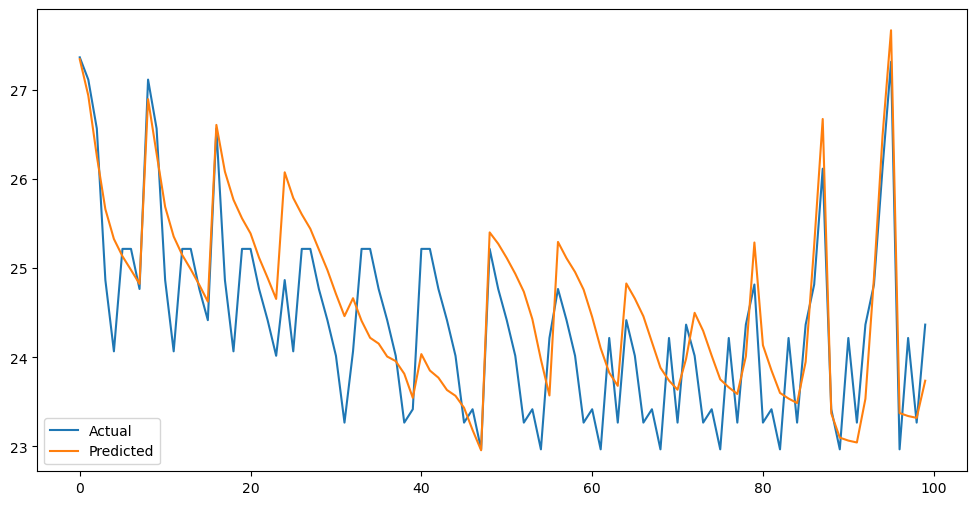

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_real[2000:2100], label="Actual")
plt.plot(preds_real[2000:2100], label="Predicted")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE (Mean Absolute Error)
mae = mean_absolute_error(actuals_real, preds_real)

# Compute RMSE (Root Mean Squared Error)
rmse = mean_squared_error(actuals_real, preds_real)

print(f"Mean Absolute Error (MAE): {mae:.3f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} °C")


from sklearn.metrics import r2_score

score = r2_score(preds_real, actuals_real)
score

Mean Absolute Error (MAE): 0.631 °C
Root Mean Squared Error (RMSE): 0.795 °C


0.9068399521660317

In [24]:
test_df = pd.read_csv('/Users/matheshanandan/Downloads/TESTING.csv')

In [25]:
test_df['date'] = pd.to_datetime(test_df['date'])

In [26]:
testing_df = test_df[15:39]

import torch
from torch.utils.data import Dataset

class WeatherDatasetTest(Dataset):
    def __init__(self, df, history_length=24, scaler = None):
       
        self.history_length = history_length  # Sequence length
        self.scaler = scaler
        self.features = self.scaler.transform(df[["temperature_2m", "relative_humidity_2m", "weather_code"]]) # Use same features
        
    def __len__(self):
        return len(self.features) - self.history_length  # Avoid out-of-range indexing

    def __getitem__(self, index):
        
        past_data = self.features[index : index + self.history_length]  # Past 24 hours

        return torch.tensor(past_data, dtype=torch.float32)  # Return as tensor


In [27]:
testing_dataset = WeatherDatasetTest(testing_df, scaler = scaler)
testing_dataset = testing_dataset[0].reshape(1,24,3)

In [28]:
testing_dataloader = DataLoader(testing_dataset, shuffle = False,drop_last=False)

In [29]:
def evaluate_testing(model, dataloader): 
    model.eval() 
    preds = []
    with torch.no_grad(): 
        for x in dataloader: 
            if probabilistic:
                mu, sigma = model(x)
                prediction = mu.cpu().numpy() 
                preds.append(prediction)
            else: 
                prediction = model(x)
                preds.append(prediction)
    return np.array(preds)

In [30]:
print("Number of batches in DataLoader:", testing_dataset.shape)


Number of batches in DataLoader: torch.Size([1, 24, 3])


In [31]:
predictions = evaluate_testing(model, testing_dataloader)

In [32]:
prediction_reshaped = predictions.reshape(-1,1)
prediction_expanded = np.zeros((prediction_reshaped.shape[0], test_dataset.features.shape[1]))
prediction_expanded[:, 0] = prediction_reshaped[:, 0]
prediction_real = test_dataset.scaler.inverse_transform(prediction_expanded)[:, 0]

In [33]:
prediction_real

array([28.60695973, 28.36923119, 28.12270769, 27.8715125 , 27.64203938,
       27.35128648, 27.04467136, 26.6882537 ])

In [34]:
 prediction_real

array([28.60695973, 28.36923119, 28.12270769, 27.8715125 , 27.64203938,
       27.35128648, 27.04467136, 26.6882537 ])

In [35]:
from IPython.display import display, Markdown
for i in range(8):
    predictions_dis = np.round(prediction_real[i],1)
    actual = test_df[39:47]['temperature_2m'].iloc[i]
    diff = np.round((actual-predictions_dis),1)
    display(Markdown(f'Actual Temperature is **{actual}**, Predicted Temperature is **{predictions_dis}**, The Difference is **{diff}**'))

Actual Temperature is **28.6**, Predicted Temperature is **28.6**, The Difference is **0.0**

Actual Temperature is **28.4**, Predicted Temperature is **28.4**, The Difference is **0.0**

Actual Temperature is **28.0**, Predicted Temperature is **28.1**, The Difference is **-0.1**

Actual Temperature is **28.0**, Predicted Temperature is **27.9**, The Difference is **0.1**

Actual Temperature is **27.8**, Predicted Temperature is **27.6**, The Difference is **0.2**

Actual Temperature is **27.5**, Predicted Temperature is **27.4**, The Difference is **0.1**

Actual Temperature is **27.4**, Predicted Temperature is **27.0**, The Difference is **0.4**

Actual Temperature is **27.0**, Predicted Temperature is **26.7**, The Difference is **0.3**